In [1]:
import numpy as np
import glob

from scipy import stats
import matplotlib.pyplot as plt

data_directory = "./vis_project_data/"

# Types of sessions/files:
session_types = ["cog", "so"]
whatdoors = ["indoor", "outdoor"]
whichs = ["base", "inter"]
ca_peer_list = ["albert", "barry", "chris", "dana"]

# Combine to single itteratable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

data_directory = "./vis_project_data/"

# Default weights adjusted to match results
cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])
so_weights = np.array([-1, 0, 1, 2, 2, 3, 5])


# Types of sessions/files:
session_types = ["cog", "so"]
whatdoors = ["indoor", "outdoor"]
whichs = ["base", "inter"]
ca_peer_list = ["albert", "barry", "chris", "dana"]

# Combine to single itteratable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

def unique_pairs():
    """Returns list of unique ca/peer pairs"""
    all_files = glob.glob(data_directory + "/*.dtx")
    list = []
    for file in all_files:
        t = file.split("-")
        list.append([t[4], t[5]])

    return np.unique(list, axis=0)

def get_files(ca, peer):
    files = []
    for ses_type, whatdoor, which in combined_scenarios:
        file_pattern = f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        files.extend(glob.glob(data_directory + file_pattern))
    return files

# get trained dyads
def get_trained_pair_files():
    ca_peer_list = unique_pairs()
    file_list = []
    for pair in ca_peer_list:
        files = get_files(pair[0], pair[1])
        if pair[1][0].upper() >= 'U' and pair[1][0].upper() <= 'Z':
            file_list.append(files)
    return file_list

# get untrained dyads
def get_untrained_pair_files():
    ca_peer_list = unique_pairs()
    file_list = []
    for pair in ca_peer_list:
        files = get_files(pair[0], pair[1])
        if pair[1][0].upper() >= 'L' and pair[1][0].upper() <= 'P':
            file_list.append(files)
    return file_list

# returns all the trials in a list for a given CA and scenario
def filter_ca_scenario(files, ses_type, which, ca, whatdoor):
    filtered_files = []
    for file_pair_list in files:
        for file in file_pair_list:
            file_name = file.split('\\')[-1]  # Extract the file name
            components = file_name.split('-')      
            #print("file components")
            #print(components)
            if len(components) >= 7 and \
                components[0] == ses_type and \
                components[-1].startswith(whatdoor) and \
                components[2] == which and \
                components[4] == ca:
                filtered_files.append(file)
    #print(filtered_files)
    return filtered_files

#filter_ca_scenario(get_trained_pair_files(), "cog", "base", "albert", "indoor")

def combined_score(filename, weights):
    """Calculates the 'score' for a single session/file.
    Assumes total session duration is 360s, otherwise returns 'nan'.
    This could be modified simply to also return other details of the session."""
    with open(filename, "r") as file:
        score = 0.0
        total_duration = 0.0
        t_end_prev = 0.0
        for count, line in enumerate(file.readlines()):
            # print(count, line)
            data = line.split(",", 4)
            if count == 0:
                continue
            if line[0] == "*":
                break

            t_catagory = int(data[0])
            t_beg = int(data[1])
            t_end = int(data[2])

            if t_beg != t_end_prev:
                print("Error, missing time stamp?")
            t_end_prev = t_end

            assert t_end >= t_beg
            if count == 1:
                assert t_beg == 0

            duration = float(t_end - t_beg)
            total_duration += duration
            score += weights[t_catagory - 1] * duration
        return score / total_duration
    
def get_ca_scenario_session_scores(files, ses_type):
    if ses_type == "so":
        weights = so_weights
    else:
        weights = cog_weights
    scores = []
    for file in files:
        temp_score = combined_score(file, weights)
        scores.append(temp_score)
    return scores # returns mean
    
def get_ca_scenario_stats(files, ses_type):
    if ses_type == "so":
        weights = so_weights
    else:
        weights = cog_weights
    scores = get_ca_scenario_session_scores(files, ses_type)
    statistics = []
    statistics.append(np.mean(scores))
    sdev = np.std(scores, ddof=1)  # "corrected" sdev
    statistics.append(sdev)
    statistics.append(sdev / np.sqrt(len(scores)))
    return statistics # returns mean, std, and standard error of mean

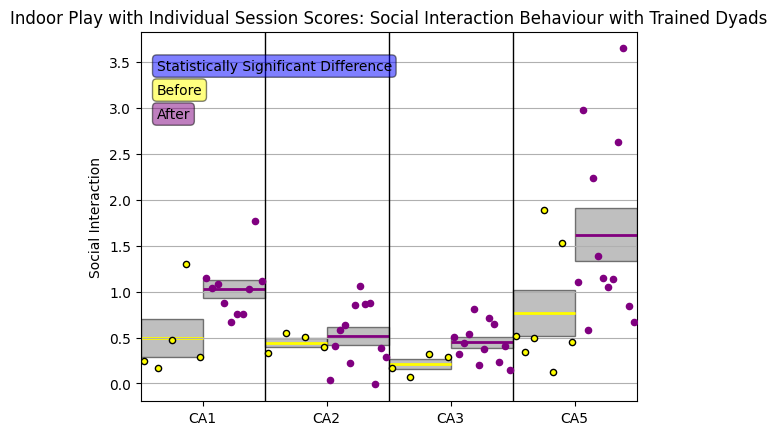

In [20]:
# get data points for graph: trained dyads indoor play social 
# before training
before_avg = []
before_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    before_avg.append(statistics[0])
    before_err.append(statistics[2])

#print(before_avg)
#print(before_err)
# after training
after_avg = []
after_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    after_avg.append(statistics[0])
    after_err.append(statistics[2])
    
#print(after_avg)
#print(after_err)

# X-axis data for "before" and "after" measurements
x_before = np.array([1, 5, 9, 13])
x_after = np.array([3, 7, 11, 15])
x_midpoints = (x_before + x_after) / 2

# Box plots for "before" and "after" data
box_y_before = []
box_y_after = []
for i in range(len(before_avg)):
    point_before = []
    point_after = []
    point_before.append(before_avg[i] - 2*before_err[i])
    point_before.append(before_avg[i])
    point_before.append(before_avg[i] + 2*before_err[i])
    point_after.append(after_avg[i] - 2*after_err[i])
    point_after.append(after_avg[i])
    point_after.append(after_avg[i] + 2*after_err[i])
    
    box_y_before.append(point_before)
    box_y_after.append(point_after)


plt.boxplot(box_y_before[1::], positions=x_before[1::], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot
plt.boxplot(box_y_after[1::], positions=x_after[1::], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot

# Change color for "CA1" data point
plt.boxplot(box_y_before[0], positions=[x_before[0]], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='blue', alpha=0.4), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot
plt.boxplot(box_y_after[0], positions=[x_after[0]], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='blue', alpha=0.4), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot

# before session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] - 2 + 0.1, x_midpoints[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='yellow', edgecolors='black', s=20, 
                zorder=10)

#after session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] + 0.1, x_after[i] + 0.9, len(y_values))
    plt.scatter(x_values, y_values, color='purple', s=20, zorder=10)
    
# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline((x_before[i+1] + x_after[i]) /2, color='black', linestyle='-', linewidth=1)
    
# Adding labels and title
plt.ylabel('Social Interaction')
plt.title('Indoor Play with Individual Session Scores: Social Interaction Behaviour with Trained Dyads')

# Customizing x-axis ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5'])

    
# Adding legend
plt.text(0.15, 0.8, "Statistically Significant Difference", bbox=dict(facecolor='blue', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.75, "Before", bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, "After", bbox=dict(facecolor='purple', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# Display the plot
plt.grid(axis='y')
plt.xlim(left=0, right = 16)
plt.show()

[0.2855555555555555, 0.5909722222222222, -0.13125, 1.7353174603174604]
[0.10163174870914606, 0.13375884552112444, 0.11398130284006822, 0.13873631074950404]
[0.7086111111111111, 0.774537037037037, 0.09351851851851851, 1.8805555555555553]
[0.07923075162298718, 0.12795370763256458, 0.07167979199273816, 0.15944915172722615]


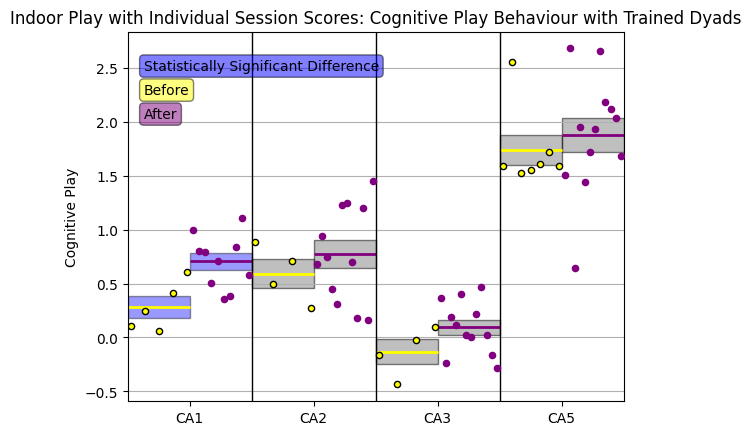

In [3]:
# get data points for graph: trained dyads indoor play cognitive 
# before training
before_avg = []
before_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "cog", "base", ca, "indoor"), "cog")
    before_avg.append(statistics[0])
    before_err.append(statistics[2])

print(before_avg)
print(before_err)
# after training
after_avg = []
after_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "cog", "inter", ca, "indoor"), "cog")
    after_avg.append(statistics[0])
    after_err.append(statistics[2])
    
print(after_avg)
print(after_err)

# X-axis data for "before" and "after" measurements
x_before = np.array([1, 5, 9, 13])
x_after = np.array([3, 7, 11, 15])
x_midpoints = (x_before + x_after) / 2

# Box plots for "before" and "after" data
box_y_before = []
box_y_after = []
for i in range(len(before_avg)):
    point_before = []
    point_after = []
    point_before.append(before_avg[i] - 2*before_err[i])
    point_before.append(before_avg[i])
    point_before.append(before_avg[i] + 2*before_err[i])
    point_after.append(after_avg[i] - 2*after_err[i])
    point_after.append(after_avg[i])
    point_after.append(after_avg[i] + 2*after_err[i])
    
    box_y_before.append(point_before)
    box_y_after.append(point_after)


plt.boxplot(box_y_before[1::], positions=x_before[1::], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot
plt.boxplot(box_y_after[1::], positions=x_after[1::], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot

# Change color for "CA1" data point
plt.boxplot(box_y_before[0], positions=[x_before[0]], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='blue', alpha=0.4), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot
plt.boxplot(box_y_after[0], positions=[x_after[0]], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='blue', alpha=0.4), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot

# before session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "cog", "base", ca, "indoor"), "cog")
    x_values = np.linspace(x_midpoints[i] - 2 + 0.1, x_midpoints[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='yellow', edgecolors='black', s=20,
                zorder=10)

#after session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "cog", "inter", ca, "indoor"), "cog")
    x_values = np.linspace(x_midpoints[i] + 0.1, x_after[i] + 0.9, len(y_values))
    plt.scatter(x_values, y_values, color='purple', s=20, zorder=10)
    
# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline((x_before[i+1] + x_after[i]) /2, color='black', linestyle='-', linewidth=1)
    
# Adding labels and title
plt.ylabel('Cognitive Play')
plt.title('Indoor Play with Individual Session Scores: Cognitive Play Behaviour with Trained Dyads')

# Customizing x-axis ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5'])

    
# Adding legend
plt.text(0.15, 0.8, "Statistically Significant Difference", bbox=dict(facecolor='blue', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.75, "Before", bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, "After", bbox=dict(facecolor='purple', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# Display the plot
plt.grid(axis='y')
plt.xlim(left=0, right = 16)
plt.show()

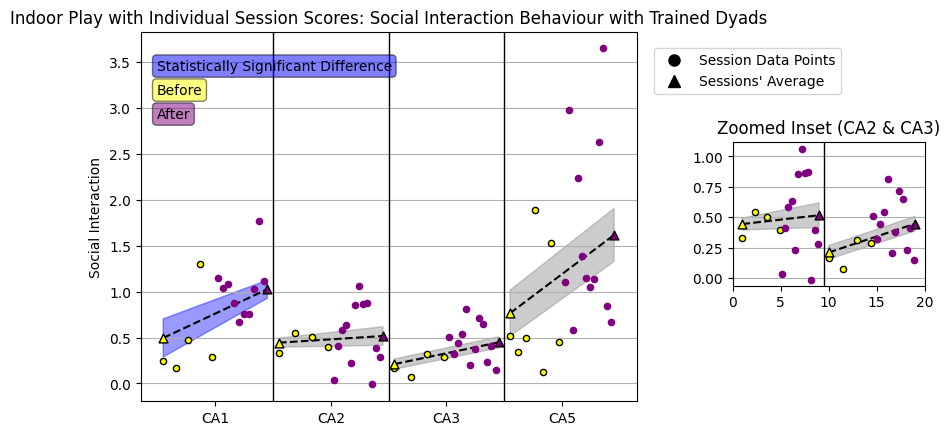

In [70]:
# individual sessions VERSIONS 2: trained dyads indoor play social 
# before training
before_avg = []
before_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    before_avg.append(statistics[0])
    before_err.append(statistics[2])

#print(before_avg)
#print(before_err)
# after training
after_avg = []
after_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    after_avg.append(statistics[0])
    after_err.append(statistics[2])
    
#print(after_avg)
#print(after_err)

# X-axis data for "before" and "after" measurements
x_before = np.array([0.2, 4.2, 8.2, 12.2])
x_after = np.array([3.8, 7.8, 11.8, 15.8])
x_midpoints = (x_before + x_after) / 2

# plot average data points with horizontal line connecting for "before" and "after" data
plt.scatter(x_before, before_avg, color='yellow', marker='^', s=40, 
            edgecolors='black', zorder=30)
plt.scatter(x_after, after_avg, color='purple', marker='^', s=40, 
            edgecolors='black', zorder=30)
for i in range(len(x_before)):
    plt.plot([x_before[i], x_after[i]], [before_avg[i], after_avg[i]], color='black', linestyle='--')

# plot uncertainty range as a fill
# Define the vertices of the polygonal patch
for i in range(1,4):
    vertices = [[x_before[i], before_avg[i] - before_err[i]],
                [x_after[i], after_avg[i] - after_err[i]],
                [x_after[i], after_avg[i] + after_err[i]],
                [x_before[i], before_avg[i] + before_err[i]]]
    # Plot the polygonal patch
    plt.fill([vertices[0][0], vertices[1][0], vertices[2][0], vertices[3][0]], 
                [vertices[0][1], vertices[1][1], vertices[2][1], vertices[3][1]], color='grey', alpha=0.4)

# add blue to CA1
vertices = [[x_before[0], before_avg[0] - before_err[0]],
                [x_after[0], after_avg[0] - after_err[0]],
                [x_after[0], after_avg[0] + after_err[0]],
                [x_before[0], before_avg[0] + before_err[0]]]
# Plot the polygonal patch
plt.fill([vertices[0][0], vertices[1][0], vertices[2][0], vertices[3][0]], 
                [vertices[0][1], vertices[1][1], vertices[2][1], vertices[3][1]], color='blue', alpha=0.4)

# before session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    x_values = np.linspace(x_before[i], x_midpoints[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='yellow', edgecolors='black', s=20, 
                zorder=10)

#after session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] + 0.1, x_after[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='purple', s=20, zorder=10)
    
# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline((x_before[i+1] + x_after[i]) /2, color='black', linestyle='-', linewidth=1)
    
# Adding labels and title
plt.ylabel('Social Interaction')
plt.title('Indoor Play with Individual Session Scores: Social Interaction Behaviour with Trained Dyads')

# Customizing x-axis ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5'])
plt.grid(axis='y')

# Inset plot for zooming into CA2 and CA3
inset_x_before = np.array([1, 10]) 
inset_x_after = np.array([9, 19]) 
inset_x_midpoints = (inset_x_before + inset_x_after) / 2
left, bottom, width, height = [1.05, 0.35, 0.3, 0.3]  # Adjust the position and size of the inset plot
ax_inset = plt.axes([left, bottom, width, height])
ax_inset.scatter(inset_x_before, before_avg[1:3], color='yellow', marker='^', s=40, edgecolors='black', zorder=30)
ax_inset.scatter(inset_x_after, after_avg[1:3], color='purple', marker='^', s=40, edgecolors='black', zorder=30)
for i in range(1, 3):
    ax_inset.plot([inset_x_before[i - 1], inset_x_after[i - 1]], [before_avg[i], after_avg[i]], color='black', linestyle='--')
for i in range(1, 3):
    vertices = [[inset_x_before[i - 1], before_avg[i] - before_err[i]],
                [inset_x_after[i - 1], after_avg[i] - after_err[i]],
                [inset_x_after[i - 1], after_avg[i] + after_err[i]],
                [inset_x_before[i - 1], before_avg[i] + before_err[i]]]
    ax_inset.fill([vertices[0][0], vertices[1][0], vertices[2][0], vertices[3][0]], 
                    [vertices[0][1], vertices[1][1], vertices[2][1], vertices[3][1]], color='grey', alpha=0.4)
for i in range(1, 3):
    y_values_before = get_ca_scenario_session_scores(filter_ca_scenario(
        get_trained_pair_files(), "so", "base", ca_peer_list[i], "indoor"), "so")
    x_values_before = np.linspace(inset_x_before[i - 1], inset_x_midpoints[i - 1] - 0.1, len(y_values_before))
    ax_inset.scatter(x_values_before, y_values_before, color='yellow', edgecolors='black', s=20, zorder=10)
for i in range(1, 3):
    y_values_after = get_ca_scenario_session_scores(filter_ca_scenario(
        get_trained_pair_files(), "so", "inter", ca_peer_list[i], "indoor"), "so")
    x_values_after = np.linspace(inset_x_midpoints[i - 1] + 0.1, inset_x_after[i - 1] - 0.1, len(y_values_after))
    ax_inset.scatter(x_values_after, y_values_after, color='purple', s=20, zorder=10)
    
plt.axvline((inset_x_before[1] + inset_x_after[0]) /2, color='black', linestyle='-', linewidth=1)
ax_inset.set_title('Zoomed Inset (CA2 & CA3)')

# Adding legend
# Define custom legend handles
circle_handle = plt.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Session Data Points')
triangle_handle = plt.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label='Sessions\' Average')

# Create legend
plt.legend(handles=[circle_handle, triangle_handle], loc='upper right', bbox_to_anchor=(0.6, 1.7))
plt.text(0.15, 0.8, "Statistically Significant Difference", bbox=dict(facecolor='blue', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.75, "Before", bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, "After", bbox=dict(facecolor='purple', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# Display the plot
plt.grid(axis='y')
plt.xlim(left=0, right = 20)
plt.show()

[[0.24444444444444444, 0.17222222222222222, 0.46944444444444444, 1.3027777777777778, 0.2916666666666667], [0.33055555555555555, 0.5472222222222223, 0.5027777777777778, 0.3972222222222222], [0.16944444444444445, 0.07222222222222222, 0.31666666666666665, 0.2861111111111111], [0.5222222222222223, 0.3416666666666667, 0.49722222222222223, 1.8888888888888888, 0.12777777777777777, 1.5277777777777777, 0.45555555555555555]]
[[1.1527777777777777, 1.0416666666666667, 1.0888888888888888, 0.875, 0.675, 0.7611111111111111, 0.7555555555555555, 1.025, 1.7722222222222221, 1.1166666666666667], [0.03611111111111111, 0.4083333333333333, 0.5805555555555556, 0.6361111111111111, 0.22777777777777777, 0.8527777777777777, 1.0638888888888889, 0.8611111111111112, 0.875, -0.011111111111111112, 0.39166666666666666, 0.2833333333333333], [0.5111111111111111, 0.3194444444444444, 0.44166666666666665, 0.5416666666666666, 0.8111111111111111, 0.20555555555555555, 0.37777777777777777, 0.7166666666666667, 0.6527777777777778

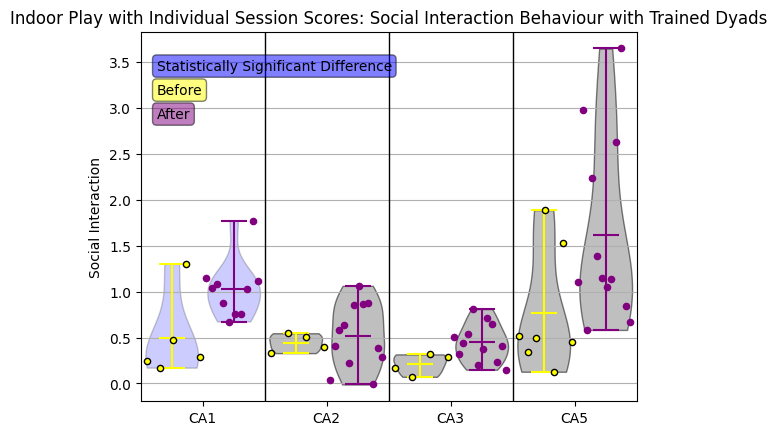

In [109]:
# individual sessions VERSIONS 3: trained dyads indoor play social 

# X-axis data for "before" and "after" measurements
x_before = np.array([1, 5, 9, 13])
x_after = np.array([3, 7, 11, 15])
x_midpoints = (x_before + x_after) / 2

# VIOLIN PLOT DATA
before_data = []
# before session data points
for i, ca in enumerate(ca_peer_list):
    before_data.append(get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so"))

print(before_data)

after_data = []
#after session data points
for i, ca in enumerate(ca_peer_list):
    after_data.append(get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so"))

print(after_data)

# PLOT DATA
# before data (excluding CA1)
fig, ax = plt.subplots()
before_violin = ax.violinplot(before_data[1::], showmeans=True, positions=x_before[1::], widths=1.7)
plt.xticks(x_before)
# change colour of statistics
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = before_violin[partname]
    vp.set_edgecolor("yellow")
    vp.set_linewidth(1.5)
# change colour of body
for pc in before_violin["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# after data (excluding CA1)
after_violin = ax.violinplot(after_data[1::], showmeans=True, positions=x_after[1::], widths=1.7)
plt.xticks(x_after)
# change colour of statistics
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = after_violin[partname]
    vp.set_edgecolor("purple")
    vp.set_linewidth(1.5)
# change colour of body
for pc in after_violin["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# plot blue CA1
before_violin_blue = ax.violinplot(before_data[0:1], showmeans=True, positions=x_before[0:1], widths=1.7)
after_violin_blue = ax.violinplot(after_data[0:1], showmeans=True, positions=x_after[0:1], widths=1.7)
# change colour of statistics
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = before_violin_blue[partname]
    vp.set_edgecolor("yellow")
    vp.set_linewidth(1.5)
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = after_violin_blue[partname]
    vp.set_edgecolor("purple")
    vp.set_linewidth(1.5)
# change colour of body
for pc in before_violin_blue["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.2)
for pc in after_violin_blue["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.2)

plt.xticks(x_before)

# INDIVIDUAL SESSION POINTS
# before session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    x_values = np.linspace(x_before[i] - 0.8, x_midpoints[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='yellow', edgecolors='black', s=20, 
                zorder=10)

#after session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] + 0.1, x_after[i] + 0.8, len(y_values))
    plt.scatter(x_values, y_values, color='purple', s=20, zorder=10)

# PLOT STYLING
# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline((x_before[i+1] + x_after[i]) /2, color='black', linestyle='-', linewidth=1)
    
# Adding labels and title
plt.ylabel('Social Interaction')
plt.title('Indoor Play with Individual Session Scores: Social Interaction Behaviour with Trained Dyads')

# Customizing x-axis ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5'])

    
# Adding legend
plt.text(0.15, 0.8, "Statistically Significant Difference", bbox=dict(facecolor='blue', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.75, "Before", bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, "After", bbox=dict(facecolor='purple', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# Display the plot
plt.grid(axis='y')
plt.xlim(left=0, right = 16)
plt.show()

In [ ]:
# individual sessions VERSIONS 3: trained dyads indoor play social 

# X-axis data for "before" and "after" measurements
x_before = np.array([1, 5, 9, 13])
x_after = np.array([3, 7, 11, 15])
x_midpoints = (x_before + x_after) / 2

# VIOLIN PLOT DATA
before_data = []
# before session data points
for i, ca in enumerate(ca_peer_list):
    before_data.append(get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so"))

print(before_data)

after_data = []
#after session data points
for i, ca in enumerate(ca_peer_list):
    after_data.append(get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so"))

print(after_data)

# PLOT DATA
# before data (excluding CA1)
fig, ax = plt.subplots()
before_violin = ax.violinplot(before_data[1::], showmeans=True, positions=x_before[1::], widths=1.7)
plt.xticks(x_before)
# change colour of statistics
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = before_violin[partname]
    vp.set_edgecolor("yellow")
    vp.set_linewidth(1.5)
# change colour of body
for pc in before_violin["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# after data (excluding CA1)
after_violin = ax.violinplot(after_data[1::], showmeans=True, positions=x_after[1::], widths=1.7)
plt.xticks(x_after)
# change colour of statistics
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = after_violin[partname]
    vp.set_edgecolor("purple")
    vp.set_linewidth(1.5)
# change colour of body
for pc in after_violin["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# plot blue CA1
before_violin_blue = ax.violinplot(before_data[0:1], showmeans=True, positions=x_before[0:1], widths=1.7)
after_violin_blue = ax.violinplot(after_data[0:1], showmeans=True, positions=x_after[0:1], widths=1.7)
# change colour of statistics
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = before_violin_blue[partname]
    vp.set_edgecolor("yellow")
    vp.set_linewidth(1.5)
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = after_violin_blue[partname]
    vp.set_edgecolor("purple")
    vp.set_linewidth(1.5)
# change colour of body
for pc in before_violin_blue["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.2)
for pc in after_violin_blue["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.2)

plt.xticks(x_before)

# INDIVIDUAL SESSION POINTS
# before session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    x_values = np.linspace(x_before[i] - 0.8, x_midpoints[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='yellow', edgecolors='black', s=20, 
                zorder=10)

#after session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] + 0.1, x_after[i] + 0.8, len(y_values))
    plt.scatter(x_values, y_values, color='purple', s=20, zorder=10)

# ERROR BARS
before_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    before_err.append(statistics[2])
plt.errorbar(x_before, y_before, yerr=before_err, fmt='o', label='Before', color='black', marker='s')

after_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    after_err.append(statistics[2])


# PLOT STYLING
# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline((x_before[i+1] + x_after[i]) /2, color='black', linestyle='-', linewidth=1)
    
# Adding labels and title
plt.ylabel('Social Interaction')
plt.title('Indoor Play with Individual Session Scores: Social Interaction Behaviour with Trained Dyads')

# Customizing x-axis ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5'])

    
# Adding legend
plt.text(0.15, 0.8, "Statistically Significant Difference", bbox=dict(facecolor='blue', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.75, "Before", bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, "After", bbox=dict(facecolor='purple', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# Display the plot
plt.grid(axis='y')
plt.xlim(left=0, right = 16)
plt.show()

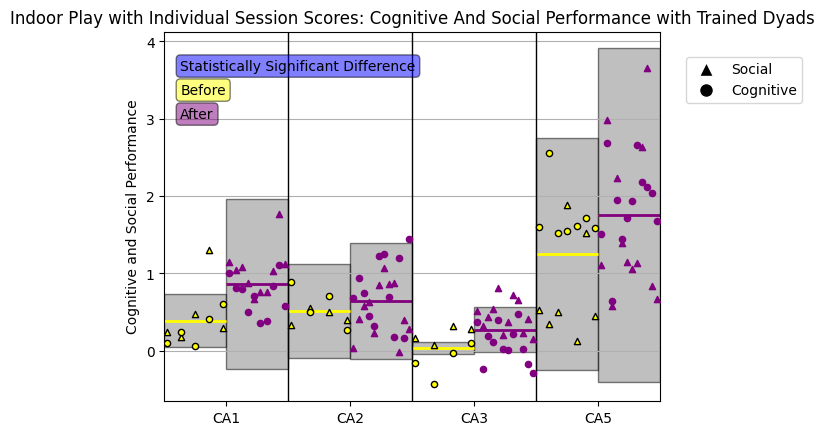

In [24]:
# indiviudal session points: trained dyads indoor play social AND cognitive 
# social data
before_avg_soc = []
before_err_soc = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    before_avg_soc.append(statistics[0])
    before_err_soc.append(statistics[2])

# after training
after_avg_soc = []
after_err_soc = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    after_avg_soc.append(statistics[0])
    after_err_soc.append(statistics[2])

# cognitive data
# before training
before_avg_cog = []
before_err_cog = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "cog", "base", ca, "indoor"), "cog")
    before_avg_cog.append(statistics[0])
    before_err_cog.append(statistics[2])

# after training
after_avg_cog = []
after_err_cog = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "cog", "inter", ca, "indoor"), "cog")
    after_avg_cog.append(statistics[0])
    after_err_cog.append(statistics[2])
    
# X-axis data for "before" and "after" measurements
x_before = np.array([1, 5, 9, 13])
x_after = np.array([3, 7, 11, 15])
x_midpoints = (x_before + x_after) / 2

# Box plots for "before" and "after" data
before_avg = (np.array(before_avg_soc) + np.array(before_avg_cog)) / 2
after_avg = (np.array(after_avg_soc) + np.array(after_avg_cog)) / 2

# calculate propagated uncertainty
def calc_propgated_uncertainty(a, b, avg):
    return np.sqrt((a-avg)**2 + (b-avg)**2)
before_err = []
after_err = []
for i in range(len(before_avg)):
    before_err.append(calc_propgated_uncertainty(before_err_soc[i], before_err_cog[i], before_avg[i]))
    after_err.append(calc_propgated_uncertainty(after_err_soc[i], after_err_cog[i], after_avg[i]))

# Create box plot data structures
box_y_before = []
box_y_after= []
for i in range(len(before_avg)):
    point_before = []
    point_after = []
    point_before.append(before_avg[i] - 2*before_err[i])
    point_before.append(before_avg[i])
    point_before.append(before_avg[i] + 2*before_err[i])
    point_after.append(after_avg[i] - 2*after_err[i])
    point_after.append(after_avg[i])
    point_after.append(after_avg[i] + 2*after_err[i])
    
    box_y_before.append(point_before)
    box_y_after.append(point_after)


plt.boxplot(box_y_before, positions=x_before, whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot
plt.boxplot(box_y_after, positions=x_after, whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot

# SOCIAL DATA POINTS
# before session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] - 2 + 0.1, x_midpoints[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='yellow', edgecolors='black', s=20, 
                zorder=10, marker='^')

#after session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] + 0.1, x_after[i] + 0.9, len(y_values))
    plt.scatter(x_values, y_values, color='purple', s=20, zorder=10, marker='^')

# COG DATA POINTS
# before session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "cog", "base", ca, "indoor"), "cog")
    x_values = np.linspace(x_midpoints[i] - 2 + 0.1, x_midpoints[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='yellow', edgecolors='black', s=20,
                zorder=10)

#after session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "cog", "inter", ca, "indoor"), "cog")
    x_values = np.linspace(x_midpoints[i] + 0.1, x_after[i] + 0.9, len(y_values))
    plt.scatter(x_values, y_values, color='purple', s=20, zorder=10)
    
# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline((x_before[i+1] + x_after[i]) /2, color='black', linestyle='-', linewidth=1)
    
# Adding labels and title
plt.ylabel('Cognitive and Social Performance')
plt.title('Indoor Play with Individual Session Scores: Cognitive And Social Performance with Trained Dyads')

# Customizing x-axis ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5'])

    
# Adding legend
legend_handles = [plt.Line2D([0], [0], marker='^', color='w', label='Social', markerfacecolor='black', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='Cognitive', markerfacecolor='black', markersize=10)]
plt.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.3, 0.95))
plt.text(0.15, 0.8, "Statistically Significant Difference", bbox=dict(facecolor='blue', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.75, "Before", bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, "After", bbox=dict(facecolor='purple', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# Display the plot
plt.grid(axis='y')
plt.xlim(left=0, right = 16)
plt.show()

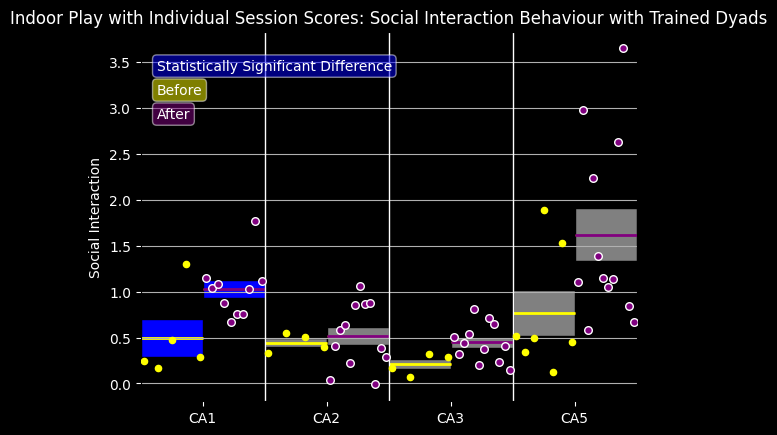

In [4]:
# INVERTED BLACK BACKGROUND
# get data points for graph: trained dyads indoor play social 
# before training

plt.figure(facecolor='black')
ax = plt.axes()
ax.set_facecolor('black')

before_avg = []
before_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    before_avg.append(statistics[0])
    before_err.append(statistics[2])

#print(before_avg)
#print(before_err)
# after training
after_avg = []
after_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    after_avg.append(statistics[0])
    after_err.append(statistics[2])
    
#print(after_avg)
#print(after_err)

# X-axis data for "before" and "after" measurements
x_before = np.array([1, 5, 9, 13])
x_after = np.array([3, 7, 11, 15])
x_midpoints = (x_before + x_after) / 2

# Box plots for "before" and "after" data
box_y_before = []
box_y_after = []
for i in range(len(before_avg)):
    point_before = []
    point_after = []
    point_before.append(before_avg[i] - 2*before_err[i])
    point_before.append(before_avg[i])
    point_before.append(before_avg[i] + 2*before_err[i])
    point_after.append(after_avg[i] - 2*after_err[i])
    point_after.append(after_avg[i])
    point_after.append(after_avg[i] + 2*after_err[i])
    
    box_y_before.append(point_before)
    box_y_after.append(point_after)


plt.boxplot(box_y_before[1::], positions=x_before[1::], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey'), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot
plt.boxplot(box_y_after[1::], positions=x_after[1::], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey'), #translucent boxes
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0)  # set behind scatter plot

# Change color for "CA1" data point
plt.boxplot(box_y_before[0], positions=[x_before[0]], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='blue'),
            capprops={"linewidth": 0}, # remove cap lines
            zorder=0) 
plt.boxplot(box_y_after[0], positions=[x_after[0]], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='blue'), 
            capprops={"linewidth": 0}, #remove cap lines
            zorder=0) # set behind scatter plot

# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline((x_before[i+1] + x_after[i]) /2, color='white', linestyle='-', linewidth=1)
    
# Adding labels and title
plt.ylabel('Social Interaction', color='white')
plt.title('Indoor Play with Individual Session Scores: Social Interaction Behaviour with Trained Dyads',
            color='white')

# Customizing ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5'], color='white')
# Adjusting axis ticks color
plt.gca().tick_params(axis='y', colors='white')
plt.gca().tick_params(axis='x', colors='white')

    
# Adding legend
plt.text(0.15, 0.8, "Statistically Significant Difference", color='white', bbox=dict(facecolor='blue', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.75, "Before", color='white', bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, "After", color='white', bbox=dict(facecolor='purple', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# before session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] - 2 + 0.1, x_midpoints[i] - 0.1, len(y_values))
    plt.scatter(x_values, y_values, color='yellow', s=20, zorder=10)

#after session data points
for i, ca in enumerate(ca_peer_list):
    y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    x_values = np.linspace(x_midpoints[i] + 0.1, x_after[i] + 0.9, len(y_values))
    plt.scatter(x_values, y_values, color='purple', s=30, zorder=10, edgecolor='white')
    
    
# Display the plot
plt.grid(axis='y')
plt.xlim(left=0, right = 16)
plt.show()